# Accessing and modelling the data from TOI4647 using the DRP photometry

In [1]:
%load_ext autoreload
%autoreload 2

from chexoplanet import newfit
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import httplib2
import numpy as np
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


['/shares/home1/hosborn/python/chexoplanet/examples', '/home/hosborn/home1/python', '/shares/home1/hosborn/python/chexoplanet/examples', '/home/hosborn/home1/anaconda3/envs/chexo/lib/python38.zip', '/home/hosborn/home1/anaconda3/envs/chexo/lib/python3.8', '/home/hosborn/home1/anaconda3/envs/chexo/lib/python3.8/lib-dynload', '', '/home/hosborn/home1/anaconda3/envs/chexo/lib/python3.8/site-packages']


### Initialising the model:

Here are some important inputs:
- `comment` - this becomes a suffix for all datafiles
- `radec` - an astropy SkyCoord object - this can help find the correct CHEOPS (and TESS) target info
- `overwrite` - Whether to overwrite all stored data
- `save_file_loc` - Where to store the saved data. Otherwise a folder is created within the chexoplanet directory

In [2]:
mod = newfit.chexo_model("TOI-4647",comment="example_drp")

Adding TESS photometry direct from the PDC files on MAST from Sectors 42, 43 & 57.

In [3]:
tess_lc_files= {'42':"https://archive.stsci.edu/missions/tess/tid/s0042/0000/0003/0320/4165/tess2021232031932-s0042-0000000303204165-0213-s_lc.fits",
                '43':"https://archive.stsci.edu/missions/tess/tid/s0043/0000/0003/0320/4165/tess2021258175143-s0043-0000000303204165-0214-s_lc.fits",
                '57':"https://archive.stsci.edu/missions/tess/tid/s0057/0000/0003/0320/4165/tess2022273165103-s0057-0000000303204165-0245-a_fast-lc.fits"}
times=[]
fluxes=[]
flux_errs=[]
h = httplib2.Http()
for sect in tess_lc_files:
    with fits.open(tess_lc_files[sect],show_progress=False) as hdus:
        times+=[hdus[1].data['TIME']]
        fluxes+=[1000*(hdus[1].data['PDCSAP_FLUX']/np.nanmedian(hdus[1].data['PDCSAP_FLUX'])-1)]
        flux_errs+=[1000*(hdus[1].data['PDCSAP_FLUX_ERR']/np.nanmedian(hdus[1].data['PDCSAP_FLUX'])-1)]


Adding the TESS lightcurve to the model. The fluxes should be in PPT and the times in BJD. Masking nans.

In [4]:
times=np.hstack(times)+2457000
fluxes=np.hstack(fluxes)
flux_errs=np.hstack(flux_errs)
mod.add_lc(time=times[np.isfinite(fluxes)],flux=fluxes[np.isfinite(fluxes)],flux_err=flux_errs[np.isfinite(fluxes)])

Getting the planetary parameters by accessing the TOI list:

In [5]:
mod.filter_TOI()
mod.add_planets_from_toi()

To check this has worked, let's print the planet dictionaries:

In [6]:
mod.planets

{'b': {'tcen': 2459451.580762,
  'tcen_err': 0.0023482225,
  'period': 8.8334569701503,
  'period_err': 7.697122e-05,
  'tdur': 0.13723686580016833,
  'depth': 0.000706920915319027,
  'b': 0.5326995467320027,
  'rprs': 0.026587984416255157,
  'K': None},
 'c': {'tcen': 2459451.352968,
  'tcen_err': 0.0038961635,
  'period': 11.070770753927,
  'period_err': 0.00013347497,
  'tdur': 0.1266234551754,
  'depth': 0.0006293319848151039,
  'b': 0.6977141292778976,
  'rprs': 0.025086490085603923,
  'K': None}}

### Initialising the TESS lightcurve

We will use a GP (from celerite) thanks to `fit_gp=True`. Alternatively, the spline-flattened TESS lightcurve can be used by setting `fit_flat=True`. The knot distance between spline breakpoints can be set using `flat_knotdist=0.9`.

In order to speed up sampling, we will bin the TESS lightcurve far away from transits by using `bin_oot=True` (and not cutting out-of-transit data, i.e. `cut_oot=False`). We set the distance from transits to cut using `cut_distance=2.25` which is in units of transit duration.

Setting `train_gp=True` will then train a simplified GP model on out-of-transit photometry in order to set priors for the full model.

Because `init_lc` also initialises the limb darkening parameters for TESS, we require stellar parameters (namely the Teff). We can give this to the model using `init_starpars` where the list is `[value,neg_err,pos_err]`.

In [7]:
mod.init_starpars(Rstar=[0.968041,0.05,0.05], Teff=[5991,130,130], logg=[4.51,0.08,0.08])
mod.init_lc(fit_gp=True, cut_oot=False, bin_oot=True, cut_distance=2.25, train_GP=True)

[5991, 130, 130] <class 'list'> <class 'int'>


[[ 2.45944770e+06 -2.64331397e-01  2.10301600e-01]
 [ 2.45944772e+06  1.56166757e-02  2.08364429e-01]
 [ 2.45944774e+06  1.34774205e-01  1.65932826e-01]
 ...
 [ 2.45988207e+06 -5.90973710e-01  1.85870321e-01]
 [ 2.45988209e+06 -6.59963547e-01  1.90963429e-01]
 [ 2.45988211e+06 -2.00994303e-01  1.62890027e-01]]
tess_logs         -0.92
log_w0            -0.68
power_log__       -1.31
tess_mean         -3.22
obs           -94271.87
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [tess_mean, power, log_w0, tess_logs]


message: Desired error not necessarily achieved due to precision loss.
logp: -94278.00319388259 -> -85499.8026249276
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tess_mean, power, log_w0, tess_logs]


Sampling 4 chains for 500 tune and 1_200 draw iterations (2_000 + 4_800 draws total) took 529 seconds.


624


### Getting CHEOPS data

You may need to add a .dacerc file in your home directory with your DACE API.

If we have a filekey, then we can run `add_cheops_lc`. For the DRP aperture photometry lightcurve, we set DRP=True. We also set ylims which cuts extremely high/low flux beyond 15ppt.

In [8]:
mod.add_cheops_lc('CH_PR149000_TG002701_V0300', download=True, ylims=(-15,15), DRP=True, PIPE=False)

#### Initialising the CHEOPS data. 

In this case, we run a CHEOPS-only model with detrending and planetary transits in order to assess exactly what detrending parameters we want to include in the full model.

Some important arguments:
- `use_bayes_fact` - Determine the detrending factors to use with a Bayes Factor
- `use_signif` - Determine the detrending factors to use by simply selecting those with significant non-zero coefficients
- `signif_thresh` - Threshold for detrending parameters in sigma when using significance (default is 1.25)


In [9]:
mod.init_cheops()

485
2460237.712788456 2460237.9191282024 0.0006947480142116547
Performing Cheops-only minimisation with all detrending params for filekey  PR149000_TG002701_V0300
bg PR149000_TG002701_V0300
centroidx PR149000_TG002701_V0300
centroidy PR149000_TG002701_V0300
time PR149000_TG002701_V0300
smear PR149000_TG002701_V0300
bg PR149000_TG002701_V0300
centroidx PR149000_TG002701_V0300
centroidy PR149000_TG002701_V0300
smear PR149000_TG002701_V0300


optimizing logp for variables: [cheops_logs, b_b, logror_b, per_b, t0_b, u_star_cheops, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: -891.6888782990334 -> -238.2423741699949
optimizing logp for variables: [d2fdsmear2, d2fdcentroidy2, d2fdcentroidx2, d2fdbg2, cheops_logs, cheops_mean, dfdsmear, dfdtime, dfdcentroidy, dfdcentroidx, dfdbg, dfdcos3phi, dfdsin3phi, dfdcos2phi, dfdsin2phi, dfdcos1phi, dfdsin1phi]


message: Optimization terminated successfully.
logp: -238.2423741699949 -> -133.87242668630253


optimizing logp for variables: [cheops_mean, d2fdsmear2, d2fdcentroidy2, d2fdcentroidx2, d2fdbg2, dfdsmear, dfdtime, dfdcentroidy, dfdcentroidx, dfdbg, dfdcos3phi, dfdsin3phi, dfdcos2phi, dfdsin2phi, dfdcos1phi, dfdsin1phi, cheops_logs, per_b, t0_b, tdur_b, b_b, logror_b, u_star_cheops, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: -133.87242668630253 -> -68.51075299580282
Only 400 samples in chain.
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [cheops_mean, d2fdsmear2, d2fdcentroidy2, d2fdcentroidx2, d2fdbg2, dfdsmear, dfdtime, dfdcentroidy, dfdcentroidx, dfdbg, dfdcos3phi, dfdsin3phi, dfdcos2phi, dfdsin2phi, dfdcos1phi, dfdsin1phi, cheops_logs, per_b, t0_b, tdur_b, b_b, logror_b, u_star_cheops, Rs]


Sampling 3 chains for 300 tune and 400 draw iterations (900 + 1_200 draws total) took 49 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


### Transit vs no transit in CHEOPS

Entirely separately, we can run a Bayesian Model Comparison using the CHEOPS data in order to see whether a transit is justified or whether a detrending-only model is a simpler/better fit. This uses a "loose" transit model (i.e. not stringently) `model_comparison_cheops` 

bg PR149000_TG002701_V0300
centroidx PR149000_TG002701_V0300
centroidy PR149000_TG002701_V0300
smear PR149000_TG002701_V0300
bg PR149000_TG002701_V0300
centroidx PR149000_TG002701_V0300
centroidy PR149000_TG002701_V0300
smear PR149000_TG002701_V0300


optimizing logp for variables: [cheops_logs, b_b, logror_b, per_b, t0_b, u_star_cheops, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: -1191.5603743609042 -> -249.09877099355995
optimizing logp for variables: [d2fdsmear2, d2fdcentroidy2, d2fdcentroidx2, d2fdbg2, cheops_logs, cheops_mean, dfdsmear, dfdcentroidy, dfdcentroidx, dfdbg, dfdcos3phi, dfdsin3phi, dfdcos2phi, dfdsin2phi, dfdcos1phi, dfdsin1phi]


message: Optimization terminated successfully.
logp: -249.09877099355995 -> -129.17375762139687
optimizing logp for variables: [cheops_mean, d2fdsmear2, d2fdcentroidy2, d2fdcentroidx2, d2fdbg2, dfdsmear, dfdcentroidy, dfdcentroidx, dfdbg, dfdcos3phi, dfdsin3phi, dfdcos2phi, dfdsin2phi, dfdcos1phi, dfdsin1phi, cheops_logs, per_b, t0_b, tdur_b, b_b, logror_b, u_star_cheops, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: -129.17375762139687 -> -128.9937973469038


Only 400 samples in chain.
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [cheops_mean, d2fdsmear2, d2fdcentroidy2, d2fdcentroidx2, d2fdbg2, dfdsmear, dfdcentroidy, dfdcentroidx, dfdbg, dfdcos3phi, dfdsin3phi, dfdcos2phi, dfdsin2phi, dfdcos1phi, dfdsin1phi, cheops_logs, per_b, t0_b, tdur_b, b_b, logror_b, u_star_cheops, Rs]


Sampling 3 chains for 300 tune and 400 draw iterations (900 + 1_200 draws total) took 154 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


bg PR149000_TG002701_V0300
centroidx PR149000_TG002701_V0300
centroidy PR149000_TG002701_V0300
time PR149000_TG002701_V0300
smear PR149000_TG002701_V0300
bg PR149000_TG002701_V0300
centroidx PR149000_TG002701_V0300
centroidy PR149000_TG002701_V0300
smear PR149000_TG002701_V0300


optimizing logp for variables: [d2fdsmear2, d2fdcentroidy2, d2fdcentroidx2, d2fdbg2, cheops_logs, cheops_mean, dfdsmear, dfdtime, dfdcentroidy, dfdcentroidx, dfdbg, dfdcos3phi, dfdsin3phi, dfdcos2phi, dfdsin2phi, dfdcos1phi, dfdsin1phi]


message: Optimization terminated successfully.
logp: -348.0199825143245 -> -128.6592554796196
optimizing logp for variables: [cheops_mean, d2fdsmear2, d2fdcentroidy2, d2fdcentroidx2, d2fdbg2, dfdsmear, dfdtime, dfdcentroidy, dfdcentroidx, dfdbg, dfdcos3phi, dfdsin3phi, dfdcos2phi, dfdsin2phi, dfdcos1phi, dfdsin1phi, cheops_logs]


message: Optimization terminated successfully.
logp: -128.6592554796196 -> -128.6592554796196


Only 400 samples in chain.
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [cheops_mean, d2fdsmear2, d2fdcentroidy2, d2fdcentroidx2, d2fdbg2, dfdsmear, dfdtime, dfdcentroidy, dfdcentroidx, dfdbg, dfdcos3phi, dfdsin3phi, dfdcos2phi, dfdsin2phi, dfdcos1phi, dfdsin1phi, cheops_logs]


Sampling 3 chains for 300 tune and 400 draw iterations (900 + 1_200 draws total) took 6 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


Index(['waic', 'waic_se', 'p_waic', 'n_samples', 'n_data_points', 'warning',
       'waic_i', 'waic_scale'],
      dtype='object')
['For fk=PR149000_TG002701_V0300 WAIC strongly prefers transit; Delta WAIC =19.12', '(BIC preferstransit with deltaBIC =-126.41). ']
For planet b the derived radius ratio is 0.02666±0.01299 which is 0.00-sigma from the expected value given TESS depth (0.02658)
cheops_only_fit_PR149000_TG002701_V0300_trace_notrans
<class 'pymc3.backends.base.MultiTrace'> True
cheops_only_fit_PR149000_TG002701_V0300_trace_loosetrans_notrend
<class 'pymc3.backends.base.MultiTrace'> True


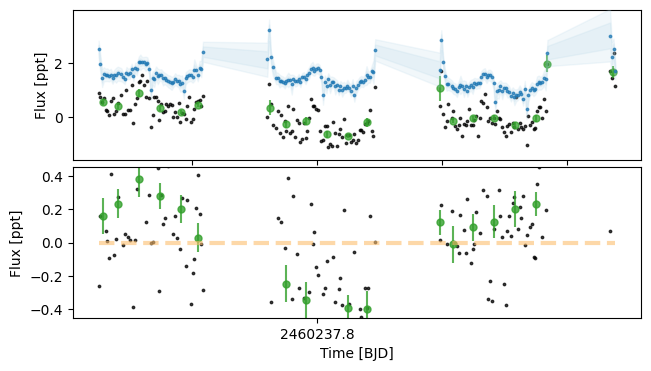

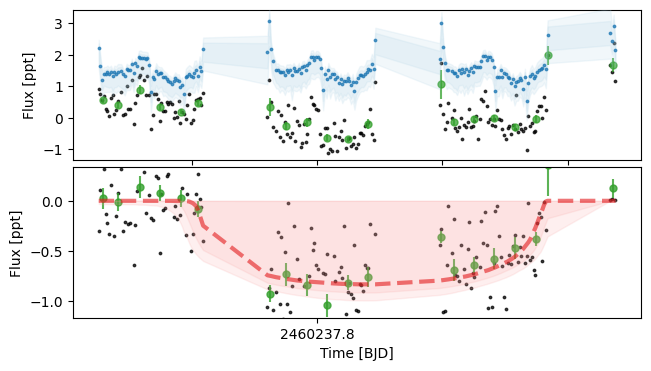

In [10]:
mod.model_comparison_cheops()

Here are the outputs, suggesting a clear preference for a transit:

For fk=PR149000_TG002701_V0300 WAIC strongly prefers transit; Delta WAIC =56.17

BIC preferstransit with deltaBIC =-12.5

For planet b the derived radius ratio is 0.02839±0.00331 which is 0.54-sigma from the expected value given TESS depth (0.02658).

### Initialising Everything

At this stage we also want to ask: "should we model rollangle flux with an additional non-linear model?". The answer is usually "yes".
The options are `fit_phi_gp` or `fit_phi_spline`
For the spline the important point is the breakpoint cadence in degrees, `spline_bkpt_cad` (default = 9) and `spline_order` (default=3). For more advanced observations with many CHEOPS visits, the spline can be split into either seperate for each visit (`phi_model_type="separate"`), common across all visits (`phi_model_type="common"`), or split into some number of separate models according to the largest time gap (`phi_model_type="split_2"` - useful for multiple seasons).


In [11]:
mod.init_model(fit_phi_gp=False, fit_phi_spline=True, spline_bkpt_cad=10, phi_model_type="common")

{'b': 8.832697589953435, 'c': 11.069892642161438} {'b': 8.834216350347164, 'c': 11.071648865692564} [8.8334569701503, 11.070770753927] 790.2189142080024
FKS= ['PR149000_TG002701_V0300']
(198, 1)
(198,)
[  8.84937219  23.24357793  38.0042042   51.423621    66.09458999
  83.88248953 222.5492976  236.03841001 251.68101919 267.24180374
 285.75996928 304.28361712 324.07371285 342.35393286 359.47735799] 6 147.43079840848895 9
PR149000_TG002701_V0300 __str__ = [ 5.34219961e-06  1.72880842e-06 -8.92177183e-07 -2.31565377e-06
 -2.37492058e-06 -9.08485918e-07  2.08876464e-06  5.83324828e-06
  9.32055303e-06  1.15706973e-05  1.16714219e-05  9.67640206e-06
  6.38256717e-06  2.61722172e-06 -7.61557387e-07 -2.99044727e-06
 -4.08369346e-06 -4.35104518e-06 -4.12646027e-06 -3.76700395e-06
 -3.45711857e-06 -3.18705541e-06 -2.95119321e-06 -2.84934721e-06
 -3.04048040e-06 -3.70308720e-06 -5.03332018e-06 -7.03147522e-06
 -9.28053734e-06 -1.12691373e-05 -1.24400013e-05 -1.22811567e-05
 -1.08984388e-05 -8.71

optimizing logp for variables: [cheops_logs, tess_logs, t0_c, P_c, logror_c, t0_b, P_b, logror_b]


message: Desired error not necessarily achieved due to precision loss.
logp: -127774.69920058908 -> -117380.9019541891
optimizing logp for variables: [splines_0, d2fdsmear2_1, d2fdcentroidx2_1, d2fdbg2_1, cheops_logs, cheops_mean_PR149000_TG002701_V0300, dfdtime_1, dfdcentroidx_1, dfdbg_1, dfdcos3phi_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -117380.9019541891 -> -116839.418859815


[b_b ~ ImpactParameter, b_c ~ ImpactParameter, logror_b ~ Uniform, logror_c ~ Uniform, tess_logs ~ Interpolated, cheops_logs ~ Normal, cheops_logs ~ Normal, u_star_tess ~ Bound-Normal, u_star_cheops ~ Bound-Normal, t0_b ~ Normal, t0_c ~ Normal, P_b ~ Bound-Normal, P_c ~ Bound-Normal, ecc_b ~ Bound-Beta, ecc_c ~ Bound-Beta, omega_b ~ Angle, omega_c ~ Angle]


optimizing logp for variables: [omega_c, omega_b, ecc_c, ecc_b, P_c, P_b, t0_c, t0_b, u_star_cheops, u_star_tess, cheops_logs, tess_logs, logror_c, logror_b, b_c, b_b]


message: Desired error not necessarily achieved due to precision loss.
logp: -116839.418859815 -> -116771.54153462518
optimizing logp for variables: [splines_0, cheops_mean_PR149000_TG002701_V0300, d2fdsmear2_1, d2fdcentroidx2_1, d2fdbg2_1, dfdtime_1, dfdcentroidx_1, dfdbg_1, dfdcos3phi_1, cheops_logs, tess_mean, phot_w0, phot_S0, tess_logs, b_c, logror_c, omega_c, ecc_c, P_c, t0_c, b_b, logror_b, omega_b, ecc_b, P_b, t0_b, u_star_cheops, u_star_tess, Ms, Rs, Teff]



Rollangle spline model is beneficial with DeltaBIC = 319.65808673274296


message: Desired error not necessarily achieved due to precision loss.
logp: -116771.54153462518 -> -115732.70123151073


### Plotting the initial model

We haven't sampled yet, but we can plot the initial model to see how the fit looks:

None
0.13723686580016833 -0.1940822368721744 0.1940822368721744
-0.6701294368754995 0.34180434696674633
0.0 0.34374021222493434


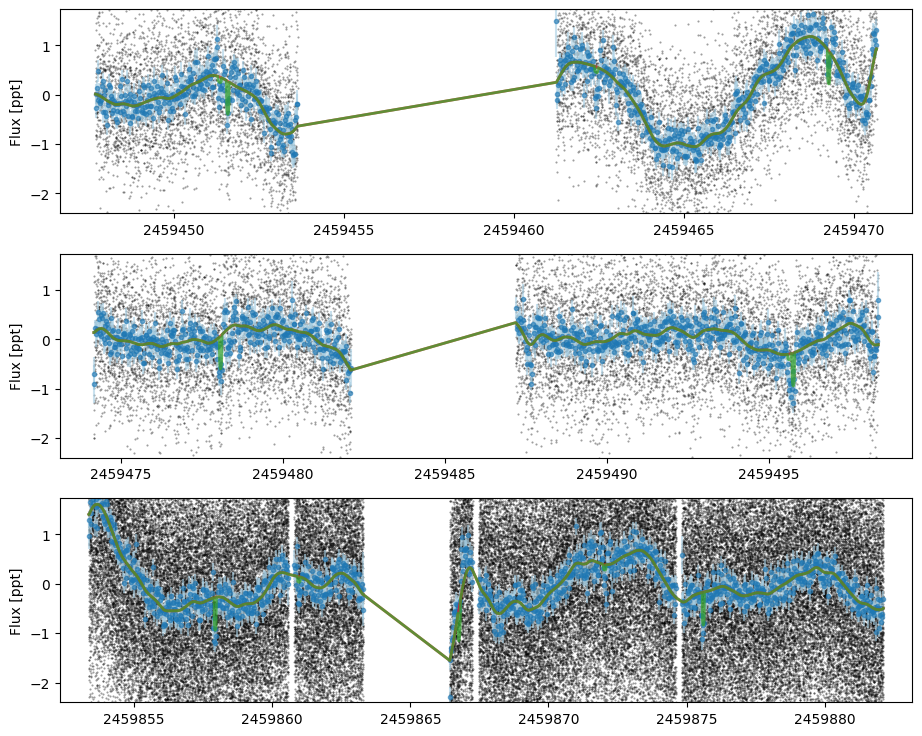

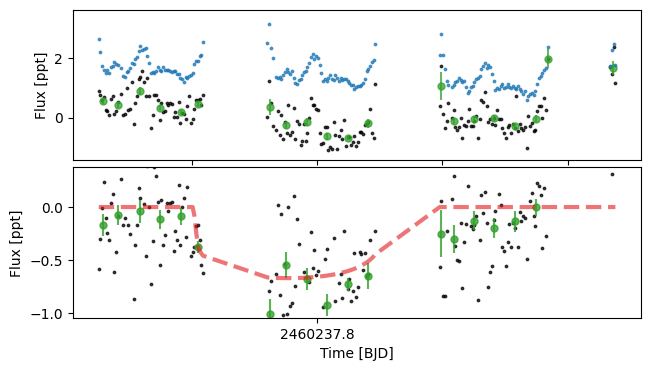

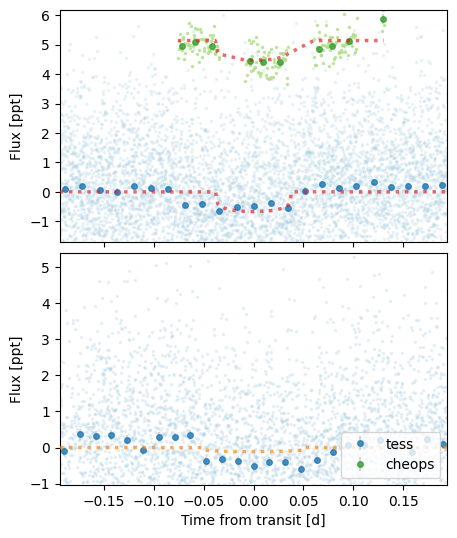

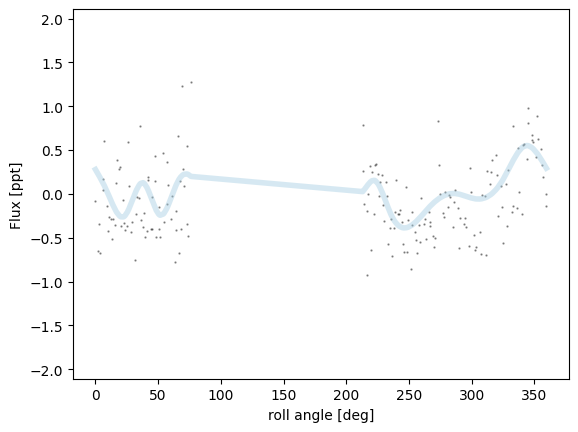

In [17]:
mod.plot_phot('tess',save=False)
mod.plot_cheops(show_detrend=True,save=False)
mod.plot_transits_fold(save=False)
mod.plot_rollangle_model(save=False)

## Sampling the model

Now we need to sample the model using PyMC3. To do this we can run `sample_model`. Possible keywords include:
- `n_tune_steps`, default is 1200
- `n_draws`, default is 10000
- `n_cores`, number of cores to use. Default is 3
- `n_chains`, chains per core, default is 3
- `regularization_steps`, a specific input to the pymc3_ext sample function, increasing this can help with divergent sampling.

I will run a scaled-back model so this doesn't take forever, but I advise >10000 steps per chain and >2000 steps tuning.

In [22]:
mod.sample_model(n_draws=800,n_tune_steps=800,n_cores=4,n_chains=1,regularization_steps=3)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [splines_0, cheops_mean_PR149000_TG002701_V0300, d2fdsmear2_1, d2fdcentroidx2_1, d2fdbg2_1, dfdtime_1, dfdcentroidx_1, dfdbg_1, dfdcos3phi_1, cheops_logs, tess_mean, phot_w0, phot_S0, tess_logs, b_c, logror_c, omega_c, ecc_c, P_c, t0_c, b_b, logror_b, omega_b, ecc_b, P_b, t0_b, u_star_cheops, u_star_tess, Ms, Rs, Teff]


Sampling 3 chains for 800 tune and 800 draw iterations (2_400 + 2_400 draws total) took 6771 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


## Saving

We can first save the important derived quantities.

1) The derived parameters can be saved using `save_trace_summary()`
2) The derived model fits (i.e. transit, GP, decorrelation and spline models) can be saved using `save_timeseries()`
3) The whole model can be saved as a pickle using `save_model_to_file()`. The file can then be reloaded using `load_model_from_file()` if the model is lost.

In [ ]:
mod.save_trace_summary()
mod.save_timeseries()
mod.save_model_to_file()

## Plotting (again)

We can now repeat the plots we did above, this time allowing them to be saved to file

In [ ]:
mod.plot_phot('tess')
mod.plot_cheops(show_detrend=True)
mod.plot_transits_fold()
mod.plot_rollangle_model()

## Making Tables

Finally we can save a few tables which might be useful. For example:
- A latex table of all CHEOPS observations used, including exposure time, cadence, average efficiency, filekey, etc, `make_cheops_obs_table()`
- A table of both priors and posteriors for all paramaters, `make_prior_posterior_table()`
- A row of data for the CHEOPS planet properties table, `MakePlanetPropertiesTable()`
- A "Model Description" of the CHEOPS observations which can be added to a paper `MakeModelDescription()` (TBD).

In [ ]:
latex_cheops_tab=mod.make_cheops_obs_table(dur_unit="orbits", incl_cad=True, incl_planets=True, incl_rms=True,incl_aveff=True)
latex_prior_tab=mod.make_prior_posterior_table()
csv_table_row - mod.MakePlanetPropertiesTable(DR2ID=2755335049254816000)

In [ ]:
print(latex_cheops_tab)
print("\n----------------------------------------n")
print(latex_prior_tab)
print("\n----------------------------------------n")
print(csv_table_row)